<a href="https://colab.research.google.com/github/SiMori92/reddit-NLP/blob/main/Inspection_%26_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content
Data: 29 Oct 2023
number of sample: 19

- Pre 1: Load libraries
- Pre 2: Load data
  - split training set & testing set

1. Data inspection
  1. meta features
  2. Embeddings
    - Load the 2 popular embedding
    - Embeddings Coverage
    - generating the oov -> then check coverage
  3. N-gram analysis (for sentiment analysis)
    - uni
    - bi
    - tri
  4. sentiment distribution
  5. topic distribution (topic modeling algorithms (e.g., LDA, NMF))

2. Data processing
  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  - goal: make the top 20 N-gram understandable
  5. Inspection after processing

3. Features engineering
  1. Frequency of words
    - N-grams
  2. Time-series
  3. Frequency of Emoji
  4. Count the number of positve comment vs negative comments
    - further: classification of comments
  5. Sentiment analysis on top n-grams
    - socre
    - embeddings and vectors
    
4. Prepare the Training dataset
- check for Duplicated labeled records

## Pre 1: Load libraries

In [ ]:
# import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

import gc
import operator

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# popular Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

!pip install bert-tensorflow
from bert import tokenization

from collections import defaultdict

import seaborn as sns

from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

## Pre 2: Load data

In [ ]:
#load excel
part1_df = pd.read_csv("2-15Jun2023.csv")
part2_df = pd.read_csv("16-28Jun2023.csv")

In [ ]:
# combine df
consol_df = pd.concat([part1_df, part2_df], ignore_index=True)
consol_df

,Unnamed: 0,title,submission_id,comments
0,12,"What Are Your Moves Tomorrow, June 15, 2023",149hiod,SPY historical average annual returns: 9%\n \...
1,13,"What Are Your Moves Tomorrow, June 14, 2023",148o6b6,I’m up 13% in Carvana and 15% in Adobe. Too b...
2,14,"What Are Your Moves Tomorrow, June 13, 2023",147w58u,"If anyone wants a good value stock, AAPL is tr..."
3,15,"What Are Your Moves Tomorrow, June 12, 2023",1473oh9,Can't wait till **Reddit IPO** for 3 reasons:\...
4,16,"What Are Your Moves Tomorrow, June 09, 2023",144jdol,This idiot sold his 235 Tesla call right befor...
5,17,"What Are Your Moves Tomorrow, June 08, 2023",143naj8,✅ Fire CEO\n\n✅ Cancel conference call\n\n✅ Mi...
6,18,"What Are Your Moves Tomorrow, June 07, 2023",142rjni,Buy a TSLA call\n \nImmediately lose ~20-30% ...
7,19,"What Are Your Moves Tomorrow, June 06, 2023",141px3u,I should move everything to t bills and never ...
8,20,"What Are Your Moves Tomorrow, June 06, 2023",1416t5j,Flash crash rug pull black swan panic sell Bou...
9,21,"What Are Your Moves Tomorrow, June 06, 2023",140ylaf,Which one of you fuckheads reported me to the ...


## 1. Data inspection

1. Meta features
2. Embedding coverage
3. N-gram analysis (for sentiment analysis)
  - uni
  - bi
  - tri
4. Sentiment distribution
5. Topic distribution (topic modeling algorithms (e.g., LDA, NMF))

##1.1. Meta Features (understand the structure)

In [ ]:
# 2. Meta Features (understand the structure between training & test dataset)

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
               'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# word_count
consol_df['word_count'] = consol_df['comments'].apply(lambda x: len(str(x).split()))

# unique_word_count
consol_df['unique_word_count'] = consol_df['comments'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
consol_df['stop_word_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
consol_df['url_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
consol_df['mean_word_length'] = consol_df['comments'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
consol_df['char_count'] = consol_df['comments'].apply(lambda x: len(str(x)))

# punctuation_count
consol_df['punctuation_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
consol_df['hashtag_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
consol_df['mention_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '@']))


In [ ]:
consol_df.describe()

,Unnamed: 0,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,12.578947,65878.210526,13600.157895,26858.421053,83.052632,4.903925,390307.947368,21719.315789,110.315789,28.210526
std,6.067361,21224.030462,3376.956524,8738.937574,38.101434,0.053640,124885.096852,6718.786953,40.503844,25.461472
min,3.000000,11247.000000,4081.000000,4351.000000,21.000000,4.821534,66055.000000,3863.000000,22.000000,3.000000
25%,7.500000,56221.000000,12888.500000,22896.000000,54.500000,4.870761,334270.500000,18831.500000,85.500000,7.000000
50%,13.000000,72595.000000,14651.000000,29293.000000,83.000000,4.906016,426934.000000,23895.000000,117.000000,14.000000
75%,17.500000,76649.500000,15666.500000,31257.000000,105.500000,4.931859,458015.500000,25713.500000,137.000000,51.500000
max,22.000000,90801.000000,17006.000000,36950.000000,163.000000,5.021993,532792.000000,28749.000000,182.000000,74.000000


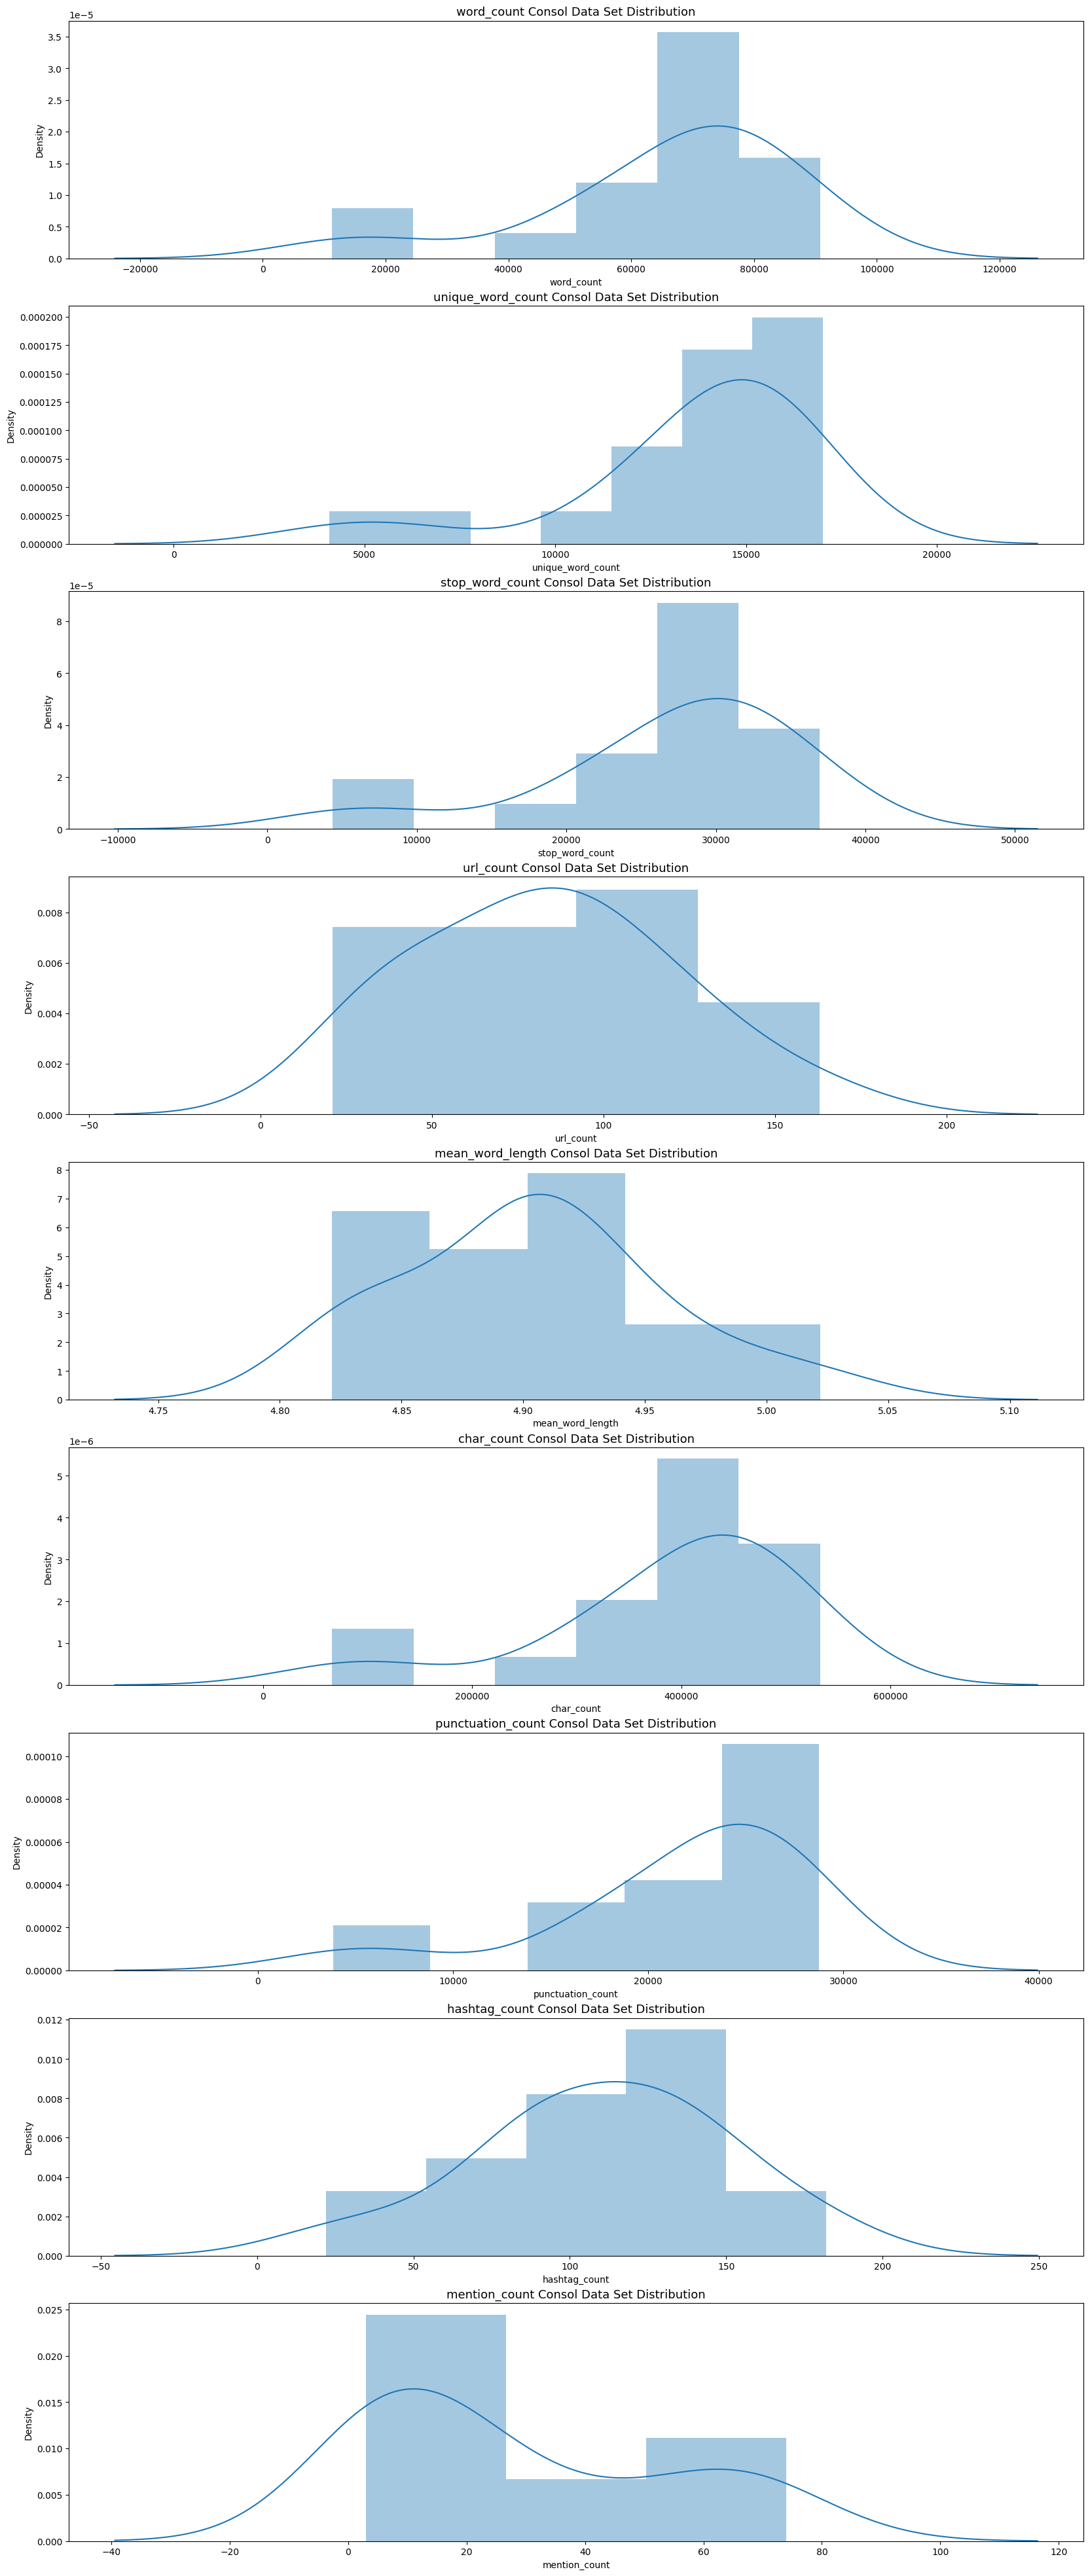

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# visualisation of meta features

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):

    sns.distplot(consol_df[feature], label='Consol', ax=axes[i])

    axes[i].set_title(f'{feature} Consol Data Set Distribution', fontsize=13)

plt.show()

## 1.2. Embeddings coverage

In [ ]:
#Load the 2 popular embedding
#glove
#fasttext

fasttext_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/crawl-300d-2M-002-001.pkl', allow_pickle=True)
glove_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/glove.840B.300d-001-002.pkl', allow_pickle=True)

In [ ]:
# Embeddings Coverage

# break the comments into words
# vocab is the unique words in the text data
def build_vocab(X):

    comments = X.apply(lambda s: s.split()).values
    vocab = {}

    for comment in comments:
        for word in comment:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

consol_glove_oov, consol_glove_vocab_coverage, consol_glove_text_coverage = check_embeddings_coverage(consol_df['comments'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_glove_vocab_coverage, consol_glove_text_coverage))

consol_fasttext_oov, consol_fasttext_vocab_coverage, consol_fasttext_text_coverage = check_embeddings_coverage(consol_df['comments'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_fasttext_vocab_coverage, consol_fasttext_text_coverage))

GloVe Embeddings cover 44.71% of vocabulary and 86.95% of text in Consol Set
FastText Embeddings cover 48.02% of vocabulary and 89.00% of text in Consol Set


In [ ]:
# generating the oov
# The purpose of generating Out-of-Vocabulary (OOV) embeddings using FastText is to provide vector representations
# - for words that are not present in the original vocabulary of the pre-trained FastText model.
# combination of character n-grams, which allows it to
# - capture the meaning of words even if they are out-of-vocabulary or misspelled.
# OOV words can negatively impact the performance of the model, and having embeddings
# - for these words can help improve the accuracy and robustness of the model.

# lump the 2 oov list as one
mergedlist = consol_glove_oov + consol_fasttext_oov

# 將新列表轉換為集合，這將刪除重複的元素
unique_set = set(mergedlist)

# 將集合轉換為列表，以便返回
total_oov = list(unique_set)
df_total_oov = pd.DataFrame(total_oov, columns = ['oov', 'oov_counts'])

# sort the oov frequency
df_total_oov_sorted = df_total_oov.sort_values(by='oov_counts', ascending=False)

# Reset the index to maintain the original order
df_total_oov_sorted = df_total_oov_sorted.reset_index(drop=True)
df_total_oov_sorted

# save as new CSV
df_total_oov_sorted.to_csv('total_oov.csv')

print(f"The counts of records in Glove OOV list is {len(consol_glove_oov)}")
print(f"The counts of records in Fasttest OOV list is {len(consol_fasttext_oov)}")
print(f"The counts of records in Total OOV list is {len(total_oov)}")


The counts of records in Glove OOV list is 54759
The counts of records in Fasttest OOV list is 51472
The counts of records in Total OOV list is 56188


## 1.3. N-gram analysis (for sentiment analysis)

In [ ]:
# 3. Ngrams(rank Ngrams in both labels)
# understand the info of Ngrams
# provide hints on text structure

def generate_ngrams(text, n_gram=1):
    # tokenisation
    # convert to lower case
    # split words based on spaces.
    # filter out empty tokens and stopwords
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]

    # grouping tokens to form n-grams
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    # joins the tokens within each ngram using the ' ' separator and as 1 string
    return [' '.join(ngram) for ngram in ngrams]

# visualisation how long of N-grams
N = 100

# Unigrams
consol_unigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt):
        consol_unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(consol_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
consol_bigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams[word] += 1

df_bigrams = pd.DataFrame(sorted(consol_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
consol_trigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams[word] += 1

df_trigrams = pd.DataFrame(sorted(consol_trigrams.items(), key=lambda x: x[1])[::-1])

df_unigrams

,0,1
0,will,5113
1,calls,3549
2,going,3208
3,market,3037
4,go,2943
...,...,...
90885,"early”,",1
90886,😃🍆,1
90887,today:\n\nbulls:,1
90888,\nnvda,1


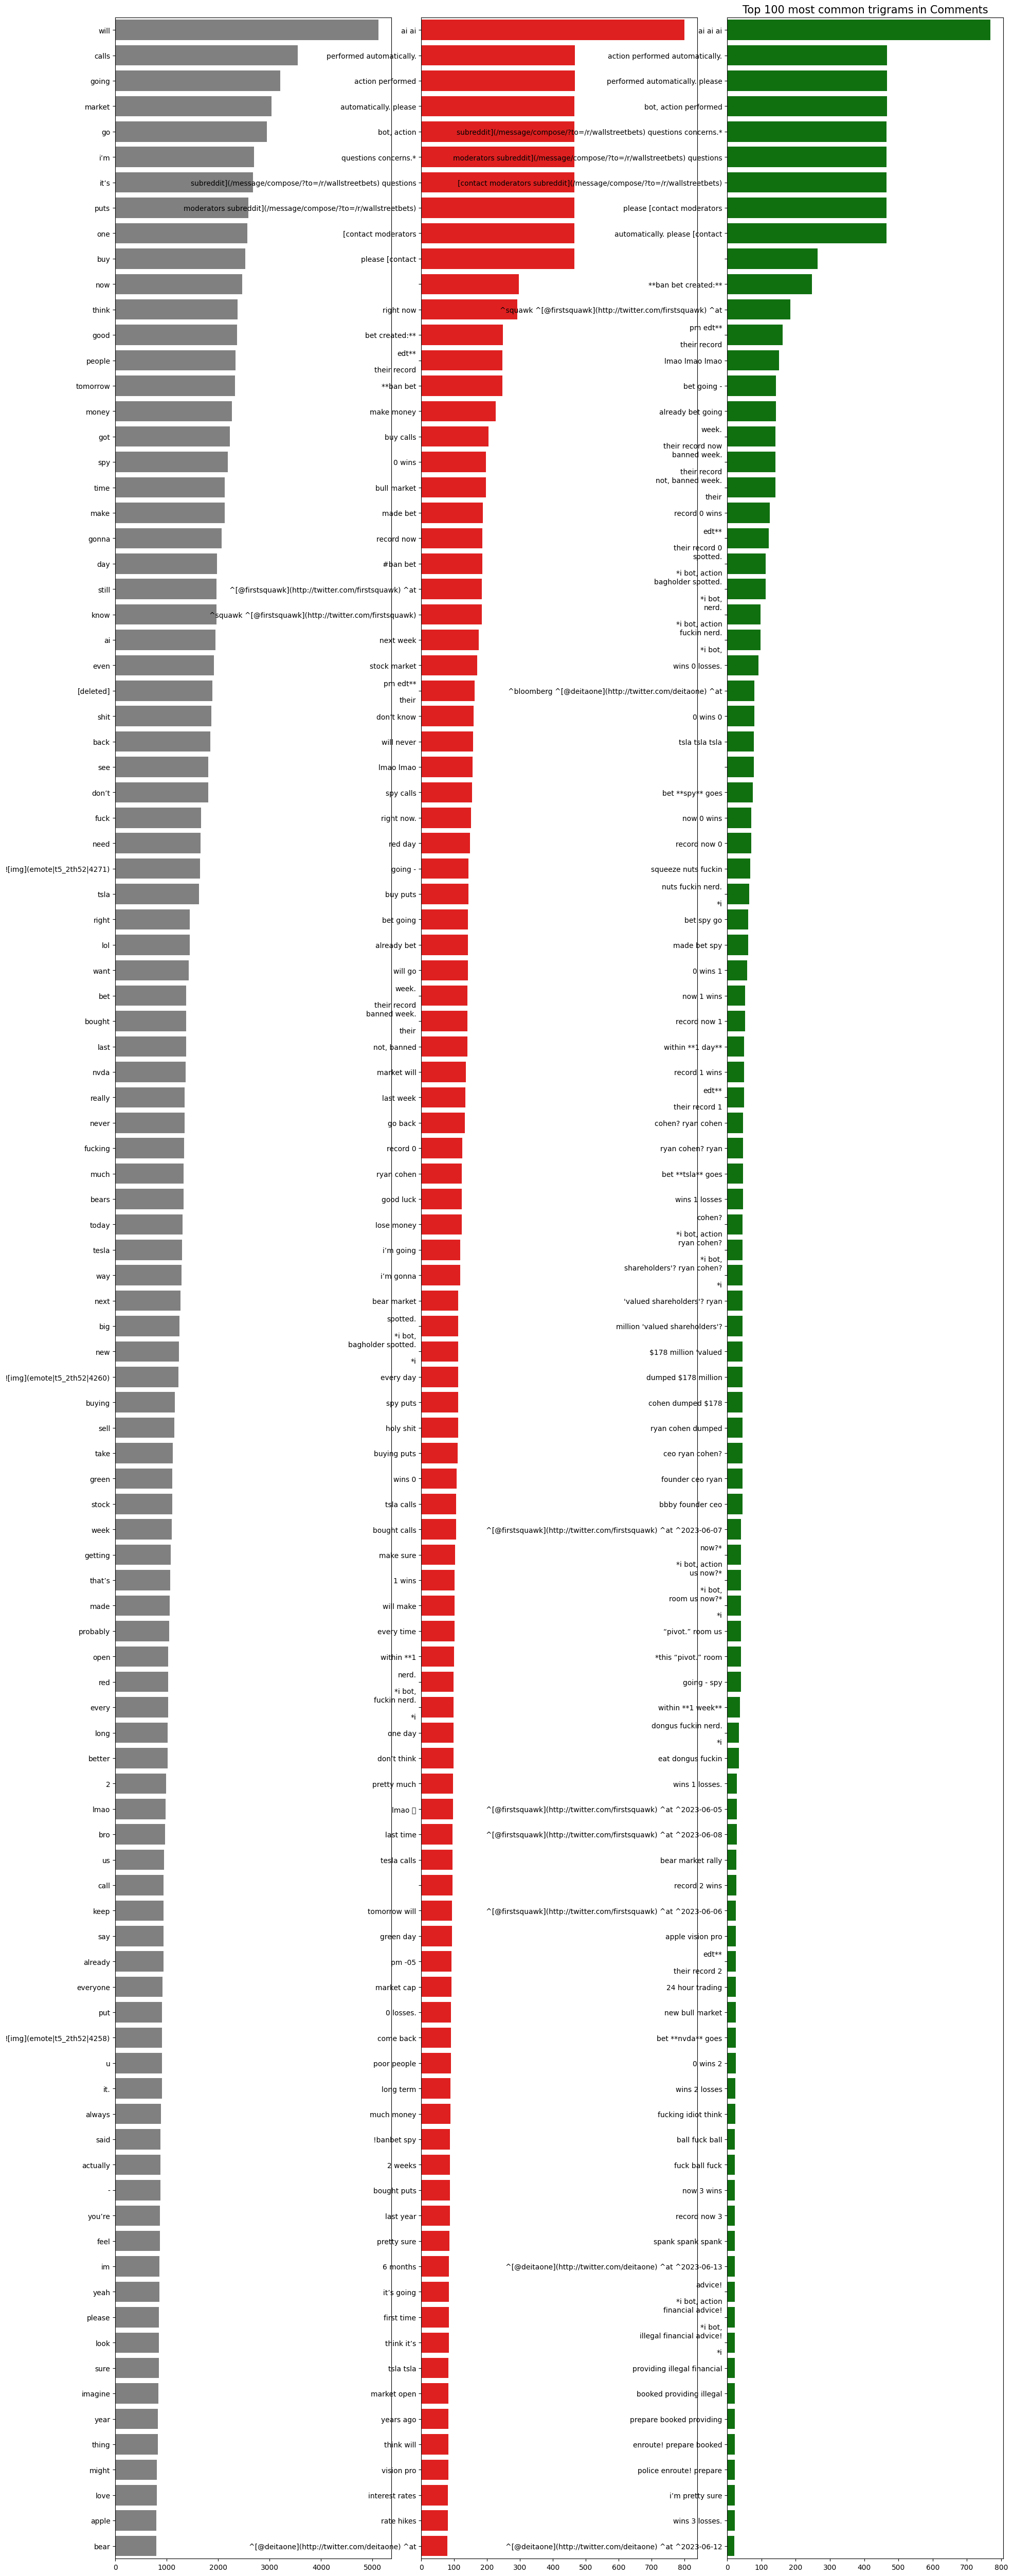

In [ ]:
# 3. Ngrams
# visualisation for Unigrams
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams[0].values[:N], x=df_unigrams[1].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Comments', fontsize=15)

sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Comments', fontsize=15)

sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Comments', fontsize=15)

plt.show()

In [ ]:
# sentiment distribution
# apply if database built can identify each comments saperately
'''
sia = SentimentIntensityAnalyzer()
#apply sentiment analysis
consol_df['sentiment'] = consol_df['comments'].apply(lambda x: sia.polarity_scores(x))

# Initialize counters for different sentiment labels
positive_count = 0
negative_count = 0
neutral_count = 0

# Count the occurrences of each sentiment label
for scores in consol_df['sentiment']:
    compound_score = scores['compound']
    if compound_score > 0.05:
        positive_count += 1
    elif compound_score < -0.05:
        negative_count += 1
    else:
        neutral_count += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(consol_df)
positive_percent = positive_count / total_count
negative_percent = negative_count / total_count
neutral_percent = neutral_count / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['green', 'red', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()
'''

"\nsia = SentimentIntensityAnalyzer()\n#apply sentiment analysis\nconsol_df['sentiment'] = consol_df['comments'].apply(lambda x: sia.polarity_scores(x))\n\n# Initialize counters for different sentiment labels\npositive_count = 0\nnegative_count = 0\nneutral_count = 0\n\n# Count the occurrences of each sentiment label\nfor scores in consol_df['sentiment']:\n    compound_score = scores['compound']\n    if compound_score > 0.05:\n        positive_count += 1\n    elif compound_score < -0.05:\n        negative_count += 1\n    else:\n        neutral_count += 1\n\n# Calculate the relative frequencies of each sentiment label\ntotal_count = len(consol_df)\npositive_percent = positive_count / total_count\nnegative_percent = negative_count / total_count\nneutral_percent = neutral_count / total_count\n\n# Visualize the sentiment distribution using a pie chart\nlabels = ['Positive', 'Negative', 'Neutral']\nsizes = [positive_percent, negative_percent, neutral_percent]\ncolors = ['green', 'red', 'gra

In [ ]:
# topic distribution (topic modeling algorithms (e.g., LDA, NMF))
# unsupervised classificaton
# apply if database built can identify each comments saperately
'''
'''

'\n'

## 2. Data processing

  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  - goal: make the top 20 N-gram understandable
  5. Inspection after processing



## 2.1 clean the comments with neutral words


In [ ]:
# option 1: NLTK - stop words

import nltk
from nltk.corpus import stopwords

In [ ]:
# option 1: NLTK - stop words
# to clean the data set

# Get the stopwords
stopwords = stopwords.words('english')

# Apply preprocessing to each comment

#decode it with utf-8

consol_df['new_text'] = consol_df['comments'].apply(lambda text: text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore'))

'''
# Tokenization
# Split the raw text into individual tokens
consol_df['new_text'] = consol_df['new_text'].apply(word_tokenize)
'''

#convert to all small case

consol_df['new_text'] = consol_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords]))

# Print the updated DataFrame
print(consol_df)

    Unnamed: 0                                        title submission_id  \
0           12  What Are Your Moves Tomorrow, June 15, 2023       149hiod   
1           13  What Are Your Moves Tomorrow, June 14, 2023       148o6b6   
2           14  What Are Your Moves Tomorrow, June 13, 2023       147w58u   
3           15  What Are Your Moves Tomorrow, June 12, 2023       1473oh9   
4           16  What Are Your Moves Tomorrow, June 09, 2023       144jdol   
5           17  What Are Your Moves Tomorrow, June 08, 2023       143naj8   
6           18  What Are Your Moves Tomorrow, June 07, 2023       142rjni   
7           19  What Are Your Moves Tomorrow, June 06, 2023       141px3u   
8           20  What Are Your Moves Tomorrow, June 06, 2023       1416t5j   
9           21  What Are Your Moves Tomorrow, June 06, 2023       140ylaf   
10          22  What Are Your Moves Tomorrow, June 02, 2023       13xroz3   
11           3  What Are Your Moves Tomorrow, June 28, 2023       14knrbs   

In [ ]:
# option 2: SK learn - ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

frozenset({'front', 'you', 'themselves', 'himself', 'against', 'she', 'ever', 'afterwards', 'everyone', 'herein', 'either', 'anyway', 'bottom', 'enough', 'hereupon', 'when', 'together', 'above', 'most', 'everything', 'nowhere', 'own', 'still', 'do', 'co', 'eleven', 'thick', 'thereupon', 'therefore', 'thereafter', 'becoming', 'describe', 'along', 'yours', 'only', 'us', 'yourselves', 'nor', 'elsewhere', 'many', 'ten', 'detail', 'or', 'anywhere', 'them', 'they', 'my', 'amount', 'much', 'have', 'and', 'this', 'ltd', 'their', 'then', 'am', 'via', 'forty', 'whether', 'somewhere', 'nothing', 'being', 'among', 'please', 'seeming', 'me', 'several', 'etc', 'myself', 'to', 'always', 'in', 'no', 'same', 'seems', 'without', 'toward', 'but', 'been', 'find', 'during', 'call', 'now', 'under', 'get', 'the', 'eight', 'anyhow', 'than', 'down', 'besides', 'rather', 'two', 'whom', 'whole', 'its', 'has', 'con', 'latterly', 'every', 'it', 'fifteen', 'may', 'up', 'next', 'interest', 'who', 'indeed', 'became',

In [ ]:
# option 2: SK learn - ENGLISH_STOP_WORDS
# to clean the date set

# Get the stopwords
stopwords_sk = ENGLISH_STOP_WORDS

#convert to lower cases
# Apply preprocessing to each comment
consol_df['new_text'] = consol_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords_sk]))

# Print the updated DataFrame
print(consol_df)

    Unnamed: 0                                        title submission_id  \
0           12  What Are Your Moves Tomorrow, June 15, 2023       149hiod   
1           13  What Are Your Moves Tomorrow, June 14, 2023       148o6b6   
2           14  What Are Your Moves Tomorrow, June 13, 2023       147w58u   
3           15  What Are Your Moves Tomorrow, June 12, 2023       1473oh9   
4           16  What Are Your Moves Tomorrow, June 09, 2023       144jdol   
5           17  What Are Your Moves Tomorrow, June 08, 2023       143naj8   
6           18  What Are Your Moves Tomorrow, June 07, 2023       142rjni   
7           19  What Are Your Moves Tomorrow, June 06, 2023       141px3u   
8           20  What Are Your Moves Tomorrow, June 06, 2023       1416t5j   
9           21  What Are Your Moves Tomorrow, June 06, 2023       140ylaf   
10          22  What Are Your Moves Tomorrow, June 02, 2023       13xroz3   
11           3  What Are Your Moves Tomorrow, June 28, 2023       14knrbs   

## 2.2. clean the text with embedding (Glove/ Fasttext) - for sentiment analysis

In [ ]:
# 1. clean the text with embedding
# clean the text
# then check coverage on the cleaned text again

%%time

# Convert 'consol_df['tokens']' column to string
consol_df['new_text'] = consol_df['new_text'].astype(str)

def clean(comment):


    # #1 - eomte

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    comment = re.sub(emote_pattern,"", comment)


    # Urls
    comment = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", comment)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`’"
    for p in punctuations:
        comment = comment.replace(p, ' ')

    return comment

consol_df['embeddings_tokens'] = consol_df['new_text'].apply(lambda s : clean(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))


GloVe Embeddings cover 78.41% of vocabulary and 96.59% of text in Training Set
FastText Embeddings cover 77.97% of vocabulary and 96.80% of text in Training Set
CPU times: user 609 ms, sys: 3.7 ms, total: 612 ms
Wall time: 624 ms


In [ ]:
# count the removed pattern
'''
def df_pattern(comment, df):

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    matches = re.findall(emote_pattern, comment)
    pattern_counts = {}

      # Count the patterns
    for match in matches:
        if match in pattern_counts:
            pattern_counts[match] += 1
        else:
            pattern_counts[match] = 1

    df_input = pd.DataFrame({'Count': list(pattern_counts.values())}, index=list(pattern_counts.keys()))
    df_transposed = df.T
    df = df.append(df_transposed, ignore_index=False)

    return df

#initialise
df_pattern = pd.DataFrame()

# Create a dataframe from the pattern counts
df_pattern = (consol_df['new_text'],df_pattern).apply(lambda s : df_pattern(s))
df_pattern['date'] = consol_df['date']

'''

'\ndef df_pattern(comment, df):\n\n    emote_pattern = r"!\\[img]\\(emote\\|[^)]*\\)"  # Regex pattern to match the desired pattern\n    matches = re.findall(emote_pattern, comment)\n    pattern_counts = {}\n\n      # Count the patterns\n    for match in matches:\n        if match in pattern_counts:\n            pattern_counts[match] += 1\n        else:\n            pattern_counts[match] = 1\n\n    df_input = pd.DataFrame({\'Count\': list(pattern_counts.values())}, index=list(pattern_counts.keys()))\n    df_transposed = df.T\n    df = df.append(df_transposed, ignore_index=False)\n\n    return df\n\n#initialise\ndf_pattern = pd.DataFrame()\n\n# Create a dataframe from the pattern counts\ndf_pattern = (consol_df[\'new_text\'],df_pattern).apply(lambda s : df_pattern(s))\ndf_pattern[\'date\'] = consol_df[\'date\']\n\n'

In [ ]:
# 1. clean the text with embedding
# save a copy of clean text

consol_df.to_csv('consol_df.csv')


In [ ]:
consol_df = pd.read_csv('consol_df.csv')

In [ ]:
# 1. clean the text with embedding
# After cleaning, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).
'''
del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()
'''

'\ndel glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,\ngc.collect()\n'

In [ ]:
# 2nd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_second[word] += 1

df_unigrams_cleaned_second = pd.DataFrame(sorted(consol_unigrams_cleaned_second.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_second[word] += 1

df_bigrams_cleaned_second = pd.DataFrame(sorted(consol_bigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_second[word] += 1

df_trigrams_cleaned_second = pd.DataFrame(sorted(consol_trigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_second

,grams,count
0,ai ai,837
1,message compose,552
2,2023 06,491
3,compose wallstreetbets,471
4,performed automatically,467
...,...,...
466254,average daily,1
466255,nvda historical,1
466256,9 nvda,1
466257,returns 9,1


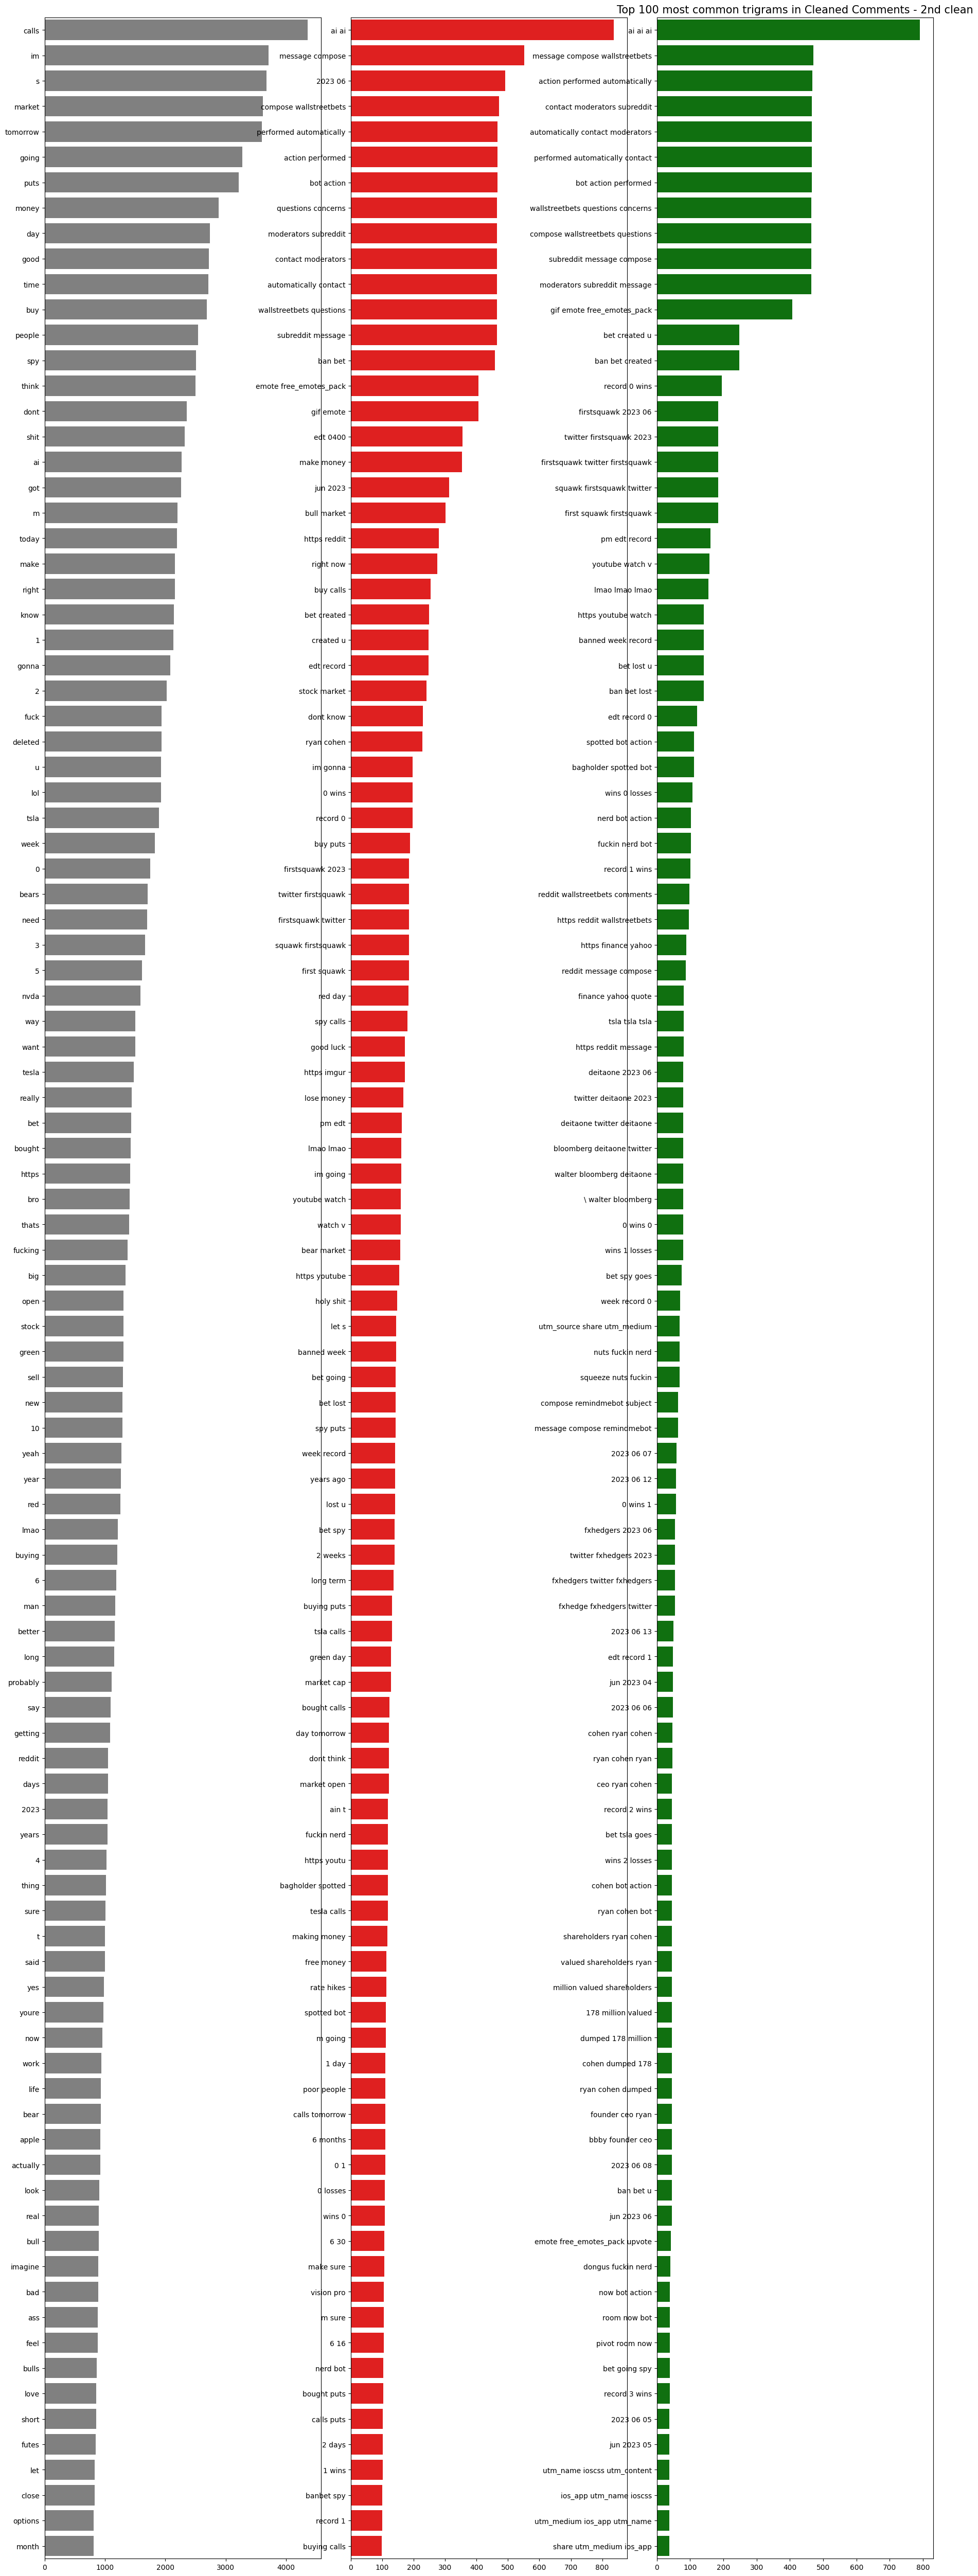

In [ ]:
# 2nd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_second['grams'].values[:N], x=df_unigrams_cleaned_second['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_second['grams'].values[:N], x=df_bigrams_cleaned_second['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_second['grams'].values[:N], x=df_trigrams_cleaned_second['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 2nd clean', fontsize=15)

plt.show()

## 2.3. Clean per N-gram

In [ ]:
# 3rd round cleaned
# criteria: by reading the N-gram ranking


%%time

def clean_second(comment):

    comment = re.sub(r"\bai ai ai\b", "ai", comment)
    comment = re.sub(r"\bai ai\b", "ai", comment)
    comment = re.sub(r'compose', '', comment)
    comment = re.sub(r'moderators', '', comment)
    comment = re.sub(r'\bm\b', '', comment)
    comment = re.sub(r'\bs\b', '', comment)
    comment = re.sub(r'\bu\b', '', comment)
    comment = re.sub(r'\b1\b', '', comment)
    comment = re.sub(r'\b2\b', '', comment)
    comment = re.sub(r'\bim\b', '', comment)
    comment = re.sub(r"   ", " ", comment)
    comment = re.sub(r"  ", " ", comment)


    return comment

consol_df['ngrams_embeddings_tokens'] = consol_df['embeddings_tokens'].apply(lambda s : clean_second(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['ngrams_embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['ngrams_embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(fasttext_vocab_coverage, fasttext_text_coverage))

GloVe Embeddings cover 78.43% of vocabulary and 96.51% of text in Training Set - 3rd clean
FastText Embeddings cover 77.99% of vocabulary and 96.73% of text in Training Set - 3rd clean
CPU times: user 1.16 s, sys: 8.1 ms, total: 1.17 s
Wall time: 1.18 s


In [ ]:
# 3rd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_third = defaultdict(int)

for cmt in consol_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_third[word] += 1

df_unigrams_cleaned_third = pd.DataFrame(sorted(consol_unigrams_cleaned_third.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_third = defaultdict(int)

for cmt in consol_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_third[word] += 1

df_bigrams_cleaned_third = pd.DataFrame(sorted(consol_bigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_third = defaultdict(int)

for cmt in consol_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_third[word] += 1

df_trigrams_cleaned_third = pd.DataFrame(sorted(consol_trigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_third

,grams,count
0,2023 06,491
1,message wallstreetbets,471
2,performed automatically,467
3,action performed,467
4,bot action,467
...,...,...
463465,average daily,1
463466,nvda historical,1
463467,9 nvda,1
463468,returns 9,1


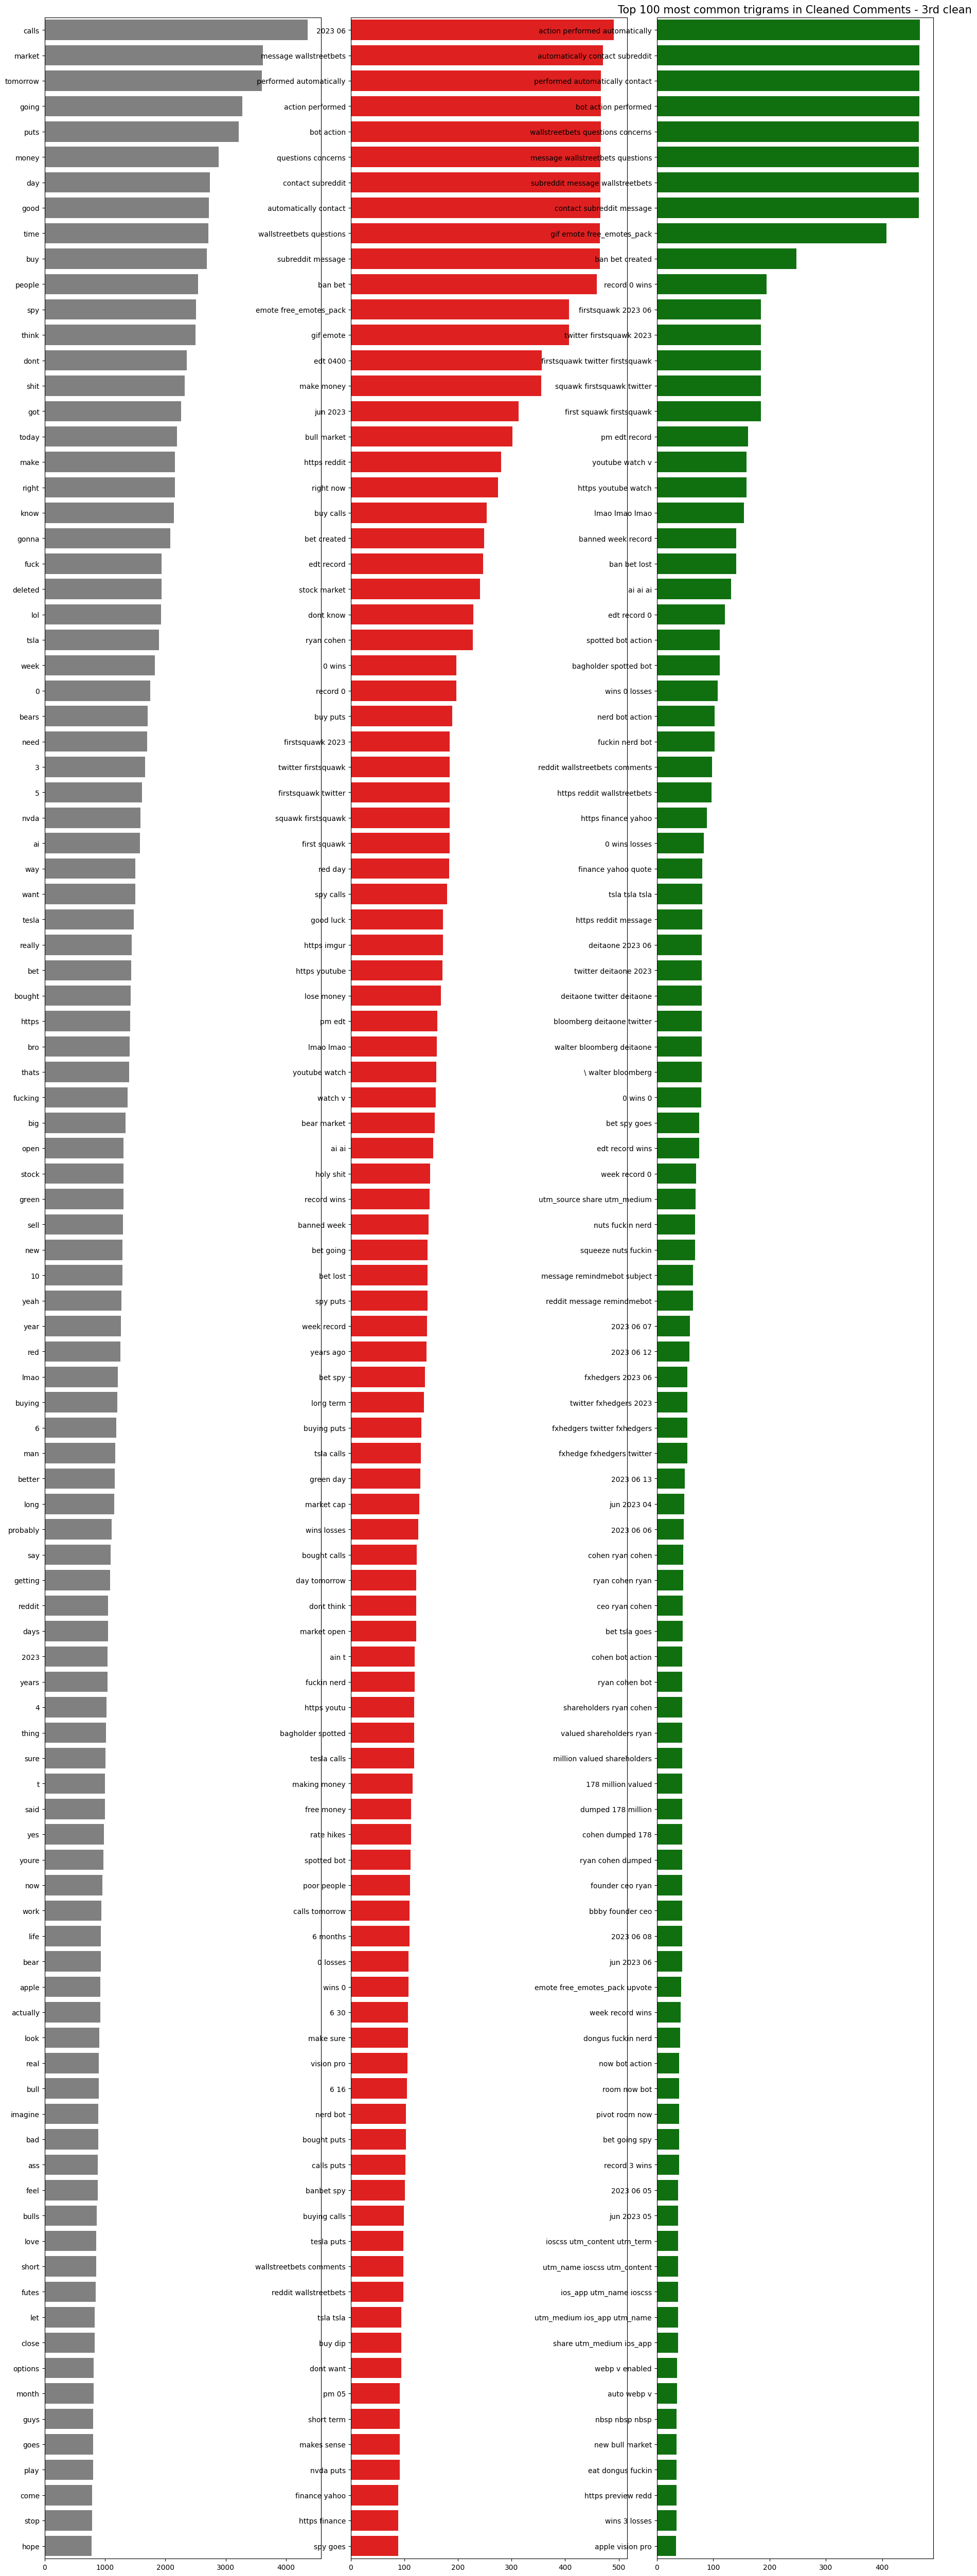

In [ ]:
# 3rd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_third['grams'].values[:N], x=df_unigrams_cleaned_third['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_third['grams'].values[:N], x=df_bigrams_cleaned_third['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_third['grams'].values[:N], x=df_trigrams_cleaned_third['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

## 2.4. Stemming or lemmatization

In [ ]:

# Stemming
consol_df['tokens'] = consol_df['ngrams_embeddings_tokens'].apply(word_tokenize)

# Step 2: Choose a Stemming or Lemmatization Algorithm
# Select a stemming or lemmatization algorithm
stemmer = PorterStemmer()

# Step 3: Apply Stemming or Lemmatization
# Apply the chosen algorithm to each token
consol_df['stemmed_tokens'] = consol_df['tokens'].apply(lambda x: [stemmer.stem(token) for token in x])
# Step 4: Reconstruct the Text
# Reconstruct the text by joining the stemmed or lemmatized tokens
consol_df['stemmed_text'] = consol_df['stemmed_tokens'].apply(lambda x: ' '.join(x))


In [ ]:
# Lemmatization


# Select a stemming or lemmatization algorithm
lemmatizer = WordNetLemmatizer()
# Apply the chosen algorithm to each token
consol_df['lemmatized_tokens'] = consol_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
# Reconstruct the text by joining the stemmed or lemmatized tokens
consol_df['lemmatized_text'] = consol_df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

##2.5. Inspection after processing

In [ ]:
#  Inspection after processing
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_final = defaultdict(int)

for cmt in consol_df['stemmed_text']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_final[word] += 1

df_unigrams_cleaned_final = pd.DataFrame(sorted(consol_unigrams_cleaned_final.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_final = defaultdict(int)

for cmt in consol_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_final[word] += 1

df_bigrams_cleaned_final = pd.DataFrame(sorted(consol_bigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_final = defaultdict(int)

for cmt in consol_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_final[word] += 1

df_trigrams_cleaned_final = pd.DataFrame(sorted(consol_trigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_final

,grams,count
0,gon na,2084
1,make money,492
2,2023 06,491
3,ban bet,472
4,messag wallstreetbet,471
...,...,...
423840,averag daili,1
423841,nvda histor,1
423842,9 nvda,1
423843,return 9,1


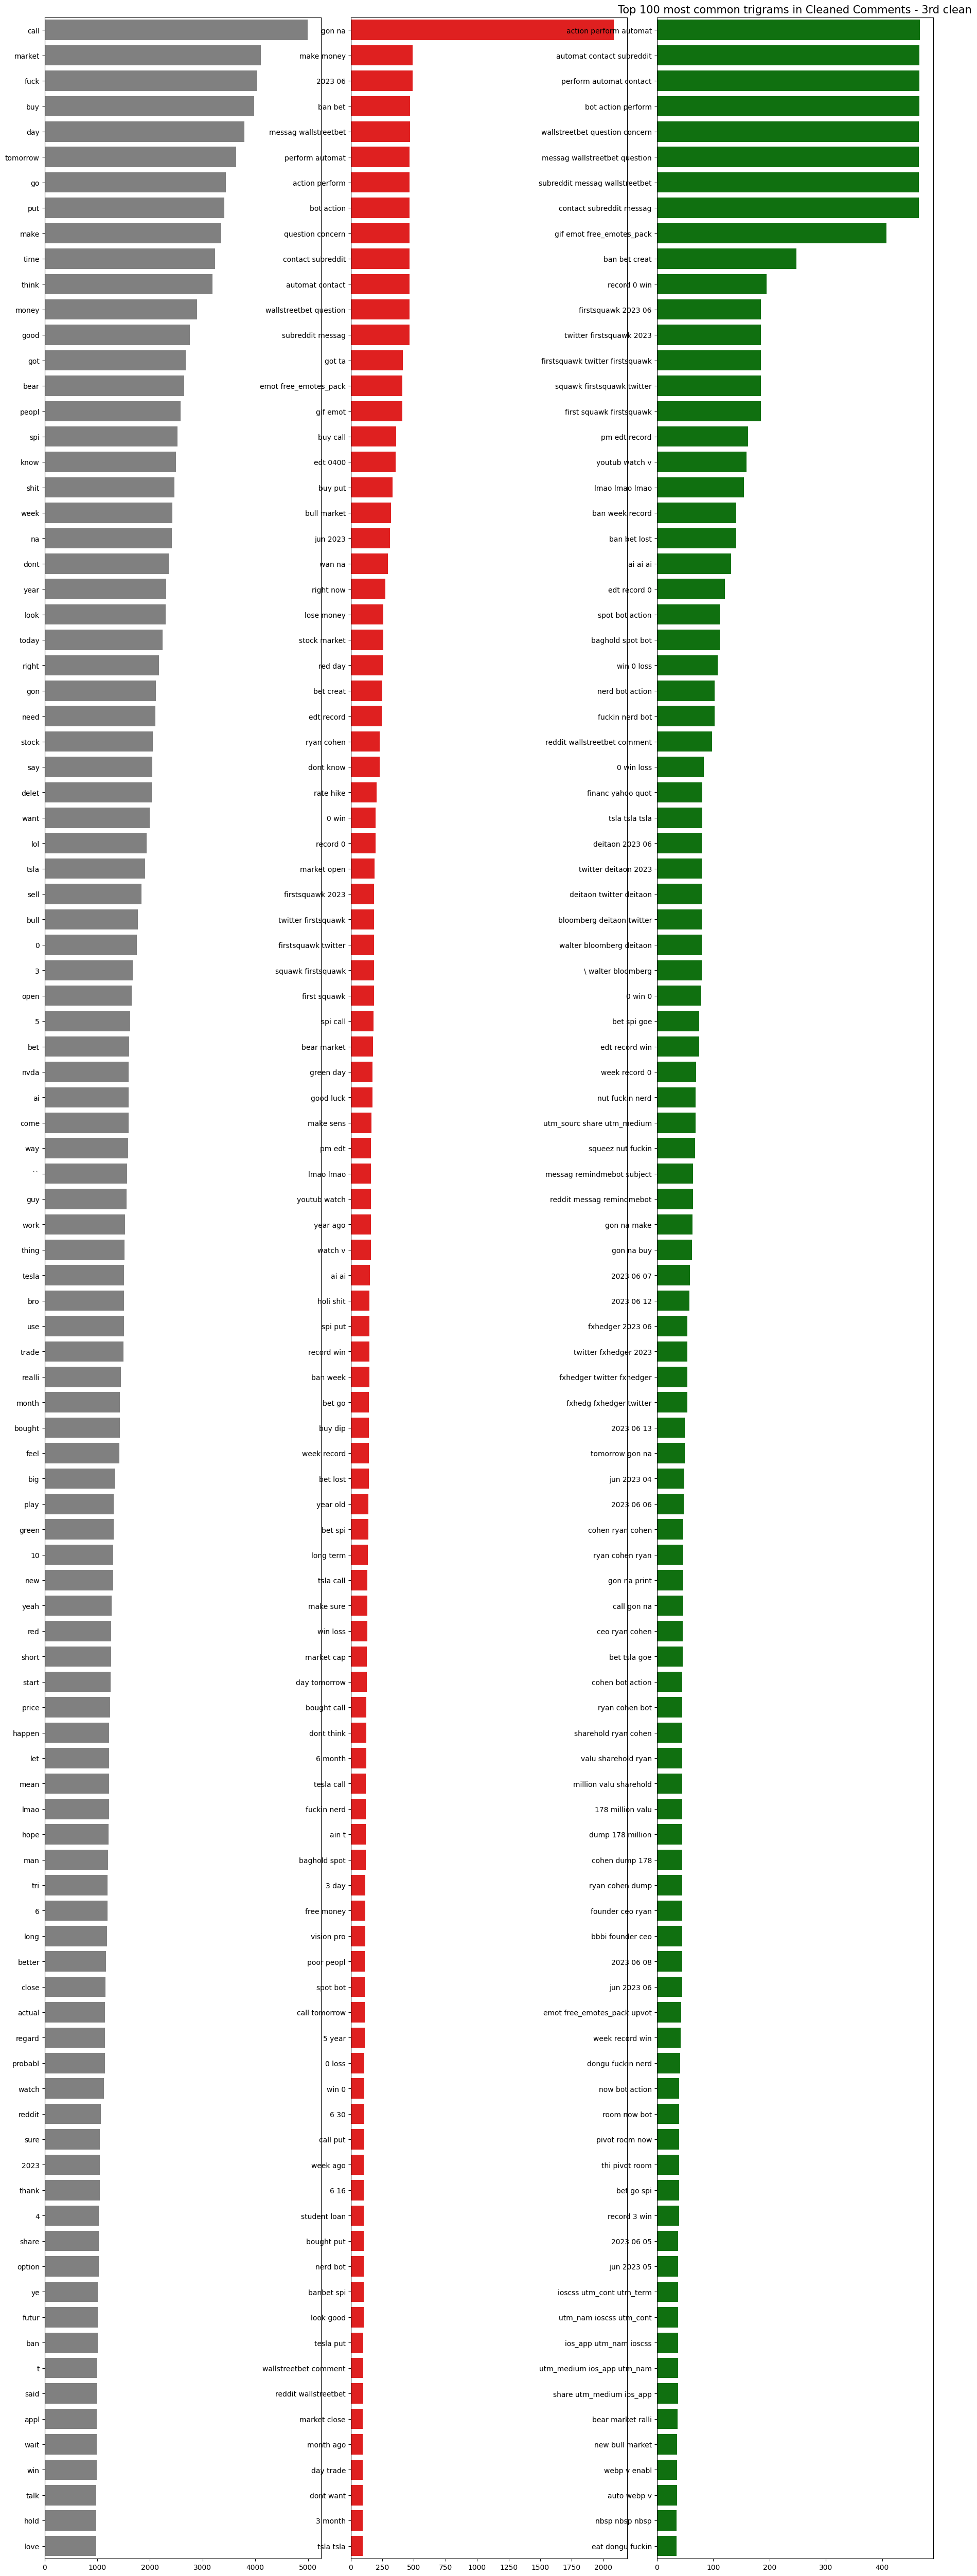

In [ ]:
# Inspection after processing
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_final['grams'].values[:N], x=df_unigrams_cleaned_final['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_final['grams'].values[:N], x=df_bigrams_cleaned_final['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_final['grams'].values[:N], x=df_trigrams_cleaned_final['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

# 3. Features engineering

  1. Sentiment analysis on top n-grams
      - option 1 - NLTK
      - option 2- BERT
  2. Topic classifification
  3. Frequency of Emoji
  4. Time-series



In [ ]:
# Generate the list of N-grams
df_unigrams_cleaned_third_tomerge = df_unigrams_cleaned_third[:20]

'''
df_bigrams_cleaned_third_tomerge = df_bigrams_cleaned_third[:20]

df_trigrams_cleaned_third_tomerge = df_trigrams_cleaned_third[:20]
'''

df_unigrams_cleaned_third_tomerge


,grams,count
0,calls,4360
1,market,3617
2,tomorrow,3598
3,going,3275
4,puts,3217
5,money,2887
6,day,2742
7,good,2718
8,time,2709
9,buy,2686


In [ ]:
# Generate the list of N-grams
# create a series contiaing first 100 unigram, bigram , trigram

list_top100gram = df_unigrams_cleaned_third_tomerge['grams']
          # pd.concat([df_unigrams_cleaned_third_tomerge['grams'] , df_bigrams_cleaned_third_tomerge['grams'] , df_trigrams_cleaned_third_tomerge['grams']], axis=0)
list_top100gram

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        calls
1       market
2     tomorrow
3        going
4         puts
5        money
6          day
7         good
8         time
9          buy
10      people
11         spy
12       think
13        dont
14        shit
15         got
16       today
17        make
18       right
19        know
Name: grams, dtype: object

In [ ]:
# Generate the list of N-grams
# create a df containings n columns each with 1 key word, each row of record shows the count of frequency of each keyword in the raw text

df_top100gram = pd.DataFrame(columns=list_top100gram, index=consol_df.index)
for i, row in consol_df.iterrows():
    for gram in list_top100gram:
        count = row['ngrams_embeddings_tokens'].count(gram)
        df_top100gram.at[i, gram] = count

df_top100gram['title'] = consol_df['title']
df_top100gram

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,calls,market,tomorrow,going,puts,money,day,good,time,buy,...,spy,think,dont,shit,got,today,make,right,know,title
0,311,387,218,225,211,223,679,179,235,306,...,169,250,150,217,233,211,194,161,176,"What Are Your Moves Tomorrow, June 15, 2023"
1,305,295,279,239,243,179,538,203,260,285,...,145,215,169,201,231,155,209,161,216,"What Are Your Moves Tomorrow, June 14, 2023"
2,292,416,316,219,269,239,612,200,254,350,...,207,255,167,210,190,170,238,166,186,"What Are Your Moves Tomorrow, June 13, 2023"
3,212,166,108,170,102,134,281,135,149,181,...,84,165,108,149,130,31,135,97,123,"What Are Your Moves Tomorrow, June 12, 2023"
4,308,299,312,224,218,182,459,141,186,272,...,177,179,108,174,145,112,153,122,144,"What Are Your Moves Tomorrow, June 09, 2023"
5,218,177,200,171,194,155,483,182,196,201,...,160,179,121,202,194,157,132,147,149,"What Are Your Moves Tomorrow, June 08, 2023"
6,240,238,169,179,188,170,447,171,224,252,...,145,201,157,155,173,92,189,145,188,"What Are Your Moves Tomorrow, June 07, 2023"
7,209,181,124,161,191,133,403,173,214,239,...,156,180,156,187,158,138,177,149,160,"What Are Your Moves Tomorrow, June 06, 2023"
8,41,32,11,17,33,29,101,31,38,39,...,33,24,20,14,21,45,29,16,17,"What Are Your Moves Tomorrow, June 06, 2023"
9,84,67,51,44,52,45,121,49,59,58,...,37,55,31,37,54,10,38,41,40,"What Are Your Moves Tomorrow, June 06, 2023"


In [ ]:
# Generate the list of N-grams
#back up the training data set

df_top100gram.to_csv('df_top20gram_Jun_testing.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# adoption of sentiment analysis models
# option 1 - NLTK

sia = SentimentIntensityAnalyzer()

#apply sentiment analysis
df_top100gram_nltk = pd.DataFrame()
df_top100gram_nltk['grams'] = list_top100gram
df_top100gram_nltk['sentiment_score'] = list_top100gram.apply(lambda x: sia.polarity_scores(x))

df_top100gram_nltk

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,grams,sentiment_score
0,calls,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,market,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,tomorrow,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,going,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,puts,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,money,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,day,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
7,good,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound..."
8,time,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,buy,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


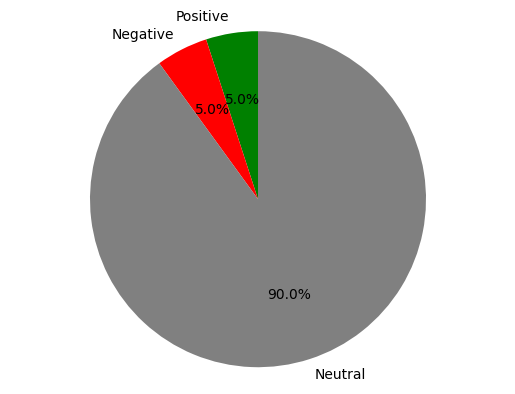

In [ ]:
# option 1 - NLTK
#Statistics

# Initialize counters for different sentiment labels
positive_count = 0
negative_count = 0
neutral_count = 0

# Count the occurrences of each sentiment label
for scores in df_top100gram_nltk['sentiment_score']:
    compound_score = scores['compound']
    if compound_score > 0.05:
        positive_count += 1
    elif compound_score < -0.05:
        negative_count += 1
    else:
        neutral_count += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(df_top100gram_nltk)
positive_percent = positive_count / total_count
negative_percent = negative_count / total_count
neutral_percent = neutral_count / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['green', 'red', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

In [ ]:
# option 2 - FinBERT

!pip install torch
!pip install transformers

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the FinBERT sentiment analysis model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# option 2 - FinBERT

# Perform sentiment analysis on each financial data point
sentiments = []

with torch.no_grad():
  for data in list_top100gram:
      inputs = tokenizer.encode_plus(data, return_tensors="pt", truncation=True)
      outputs = model(**inputs)
      logits = outputs.logits
      probabilities = torch.softmax(logits, dim=1).tolist()[0]
      label = "positive" if probabilities[1] >= probabilities[0] else "negative"
      score = probabilities[1] if label == "positive" else probabilities[0]
      sentiment = {
          "Text": data,
          "Sentiment": label,
          "Score": score
      }
      sentiments.append(sentiment)

# Convert sentiments list to a pandas DataFrame
df_top100gram_bert = pd.DataFrame(sentiments)

df_top100gram_bert

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Sentiment,Score
0,calls,negative,0.093550
1,market,negative,0.066315
2,tomorrow,negative,0.038808
3,going,negative,0.083423
4,puts,negative,0.115403
5,money,negative,0.085855
6,day,negative,0.071400
7,good,negative,0.141264
8,time,negative,0.079210
9,buy,negative,0.063705


In [ ]:
df_top100gram_bert.to_csv('gram_bert.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


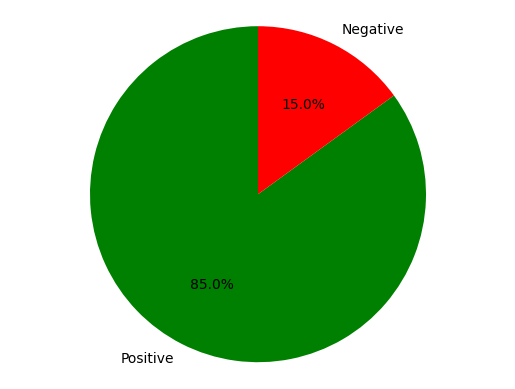

In [ ]:
# option 2 - Flair
#Statistics

# Initialize counters for different sentiment labels
positive_count_bert = 0
negative_count_bert = 0

# Count the occurrences of each sentiment label
for result in df_top100gram_bert['sentiment_score']:
    bert_label = result[0]['label']
    if bert_label == 'POSITIVE':
        positive_count_bert += 1
    else:
        negative_count_bert += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(df_top100gram_bert)
positive_percent_bert = positive_count_bert / total_count
negative_percent_bert = negative_count_bert / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative']
sizes = [positive_percent_bert, negative_percent_bert]
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

# 4. Prepare the Training dataset
  - check for Duplicated labeled records

In [ ]:
# 2. Prepare the Training dataset
# Check for Duplicated labeled records
'''
# extract the list of "text"
df_mislabeled = consol_df.groupby(['comments']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

'''

'\n# extract the list of "text"\ndf_mislabeled = consol_df.groupby([\'comments\']).nunique().sort_values(by=\'target\', ascending=False)\ndf_mislabeled = df_mislabeled[df_mislabeled[\'target\'] > 1][\'target\']\ndf_mislabeled.index.tolist()\n\n'

In [ ]:
# Check for Duplicated labeled records
# review and relabel the text one by one

what if the keyword is new and never trained before in model?
- Ngrams & embeddings


In [ ]:
'''
# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證
# 為了確保每個子集都能夠代表整個資料集的類別分佈
K = 3
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = train_df['target'] == 1
print('Whole Training Set Shape = {}'.format(train_df.shape))
print('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))

#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列
# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合
# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, train_df.loc[trn_idx, 'keyword'].nunique(), train_df.loc[val_idx, 'keyword'].nunique()))


'''

"\n# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證\n# 為了確保每個子集都能夠代表整個資料集的類別分佈\nK = 3\nskf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)\n\nDISASTER = train_df['target'] == 1\nprint('Whole Training Set Shape = {}'.format(train_df.shape))\nprint('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))\nprint('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))\n\n#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列\n# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合\n# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證\nfor fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):\n    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'tex